In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet

2024-11-26 14:51:25.053202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 14:51:25.551788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-26 14:51:25.551842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-11-26 14:51:25.551848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_025_SMOTE.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print("")
print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)
print("")
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(2624, 100, 12) (2624,)
(2624,)

(4056, 100, 12) (4056,)
(4056,)

(7887, 100, 12) (7887,)


In [6]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

In [13]:
def k_fold_finetune_resnet(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        if weights_path:
            fine_tuned_model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in fine_tuned_model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
        history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train.shape[0]//batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        
        
        print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc},Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            fine_tuned_model.save_weights(f'model-weights/fine-tuned/025/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
        
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")
    
    # load best model
    fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
    fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    fine_tuned_model.load_weights(f'model-weights/fine-tuned/025/{name}')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = fine_tuned_model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")

# No Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8395833373069763, Val Precision: 0.898876428604126, Val Recall: 0.5405405163764954, Val AUC: 0.9434833930315858, Val F1 Score: 0.6751054731857079
Test Accuracy: 0.9207556843757629, Test Precision: 0.9816201329231262, Test Recall: 0.70686274766922, Test AUC: 0.9422272859887927,Test F1 Score: 0.8218865732083055

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.8998144865036011, Val Precision: 0.9411764740943909, Val Recall: 0.6666666865348816, Val AUC: 0.9745604781997187, Val F1 Score: 0.7804878196994297
Test Accuracy: 0.9036388993263245, Test Precision: 0.9644412398338318, Test Recall: 0.6514706015586853, Test AUC: 0.9449033273305901,Test F1 Score: 0.7776477634338106

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9485294222831726, Val Precision: 0.7254902124404907, Val Recall: 1.0, Val AUC: 0.9948533640023002, Val

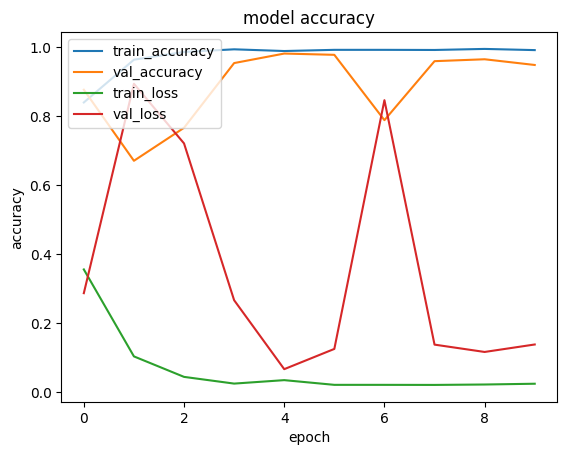

K-Fold Results:
Acuracy: 0.8953757166862488 	 +/- 0.035474162431556266
Precision: 0.8273294925689697 	 +/- 0.09301000996672681
Recall: 0.7420475006103515 	 +/- 0.19044370460107765
AUC: 0.9550032049819833 	 +/- 0.028385158309588036
F1: 0.7575525262168438 	 +/- 0.06677884985831947


247/247 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.898567259311676, Test Precision: 0.7707423567771912, Test Recall: 0.8651960492134094, Test AUC: 0.9372393501611352, Test F1 Score: 0.815242480527582


In [14]:
# no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="no_pretrain_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9166666865348816, Val Precision: 0.9090909361839294, Val Recall: 0.8108108043670654, Val AUC: 0.9827824812764572, Val F1 Score: 0.8571428655848208
Test Accuracy: 0.9464942216873169, Test Precision: 0.9499443769454956, Test Recall: 0.8372548818588257, Test AUC: 0.9595557634717988,Test F1 Score: 0.890046885565588

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9035250544548035, Val Precision: 0.859375, Val Recall: 0.7638888955116272, Val AUC: 0.972556258790436, Val F1 Score: 0.8088235331241647
Test Accuracy: 0.9164447784423828, Test Precision: 0.9581950902938843, Test Recall: 0.7078431248664856, Test AUC: 0.9407604704272678,Test F1 Score: 0.8142091829268875

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9797794222831726, Val Precision: 1.0, Val Recall: 0.8513513803482056, Val AUC: 0.9615296147211041, Val F1 Score

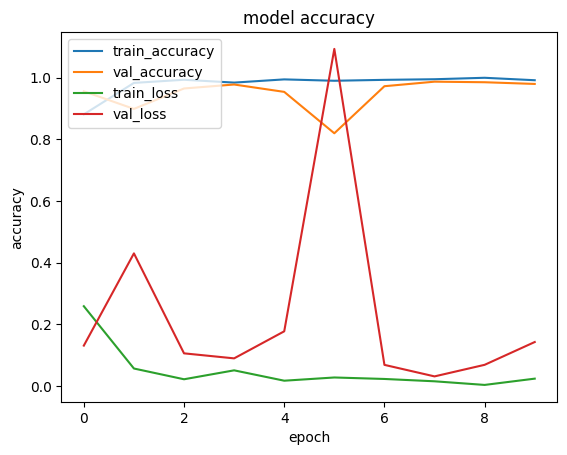

K-Fold Results:
Acuracy: 0.9174192309379577 	 +/- 0.03550467953210408
Precision: 0.8730024456977844 	 +/- 0.10948732291887445
Recall: 0.7811192989349365 	 +/- 0.06936494453651765
AUC: 0.9567501720835097 	 +/- 0.02215267113048147
F1: 0.8186409777602355 	 +/- 0.06404429263244468


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9097248911857605, Test Precision: 0.8755655884742737, Test Recall: 0.7588235139846802, Test AUC: 0.9234895890971405, Test F1 Score: 0.8130251915783299


In [ ]:
# smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="no_pretrain_smote.h5")

# Supervised Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.862500011920929, Val Precision: 1.0, Val Recall: 0.5540540814399719, Val AUC: 0.9727898078801693, Val F1 Score: 0.7130435009399295
Test Accuracy: 0.9246861934661865, Test Precision: 0.9652509689331055, Test Recall: 0.7352941036224365, Test AUC: 0.9535654701422214,Test F1 Score: 0.8347245332412969

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9109461903572083, Val Precision: 0.7891566157341003, Val Recall: 0.9097222089767456, Val AUC: 0.96179676511955, Val F1 Score: 0.8451612784289421
Test Accuracy: 0.915303647518158, Test Precision: 0.8149678707122803, Test Recall: 0.8700980544090271, Test AUC: 0.9513355265143513,Test F1 Score: 0.8416311173838193

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 1.0, Val Precision: 1.0, Val Recall: 1.0, Val AUC: 1.0, Val F1 Score: 1.0
Test Accuracy: 0.9438316226005554, Test Precis

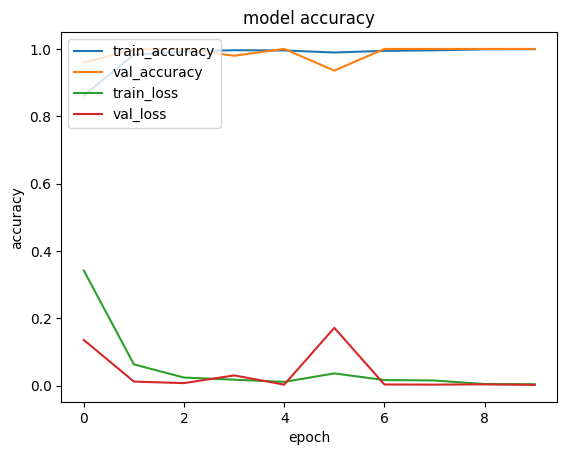

K-Fold Results:
Acuracy: 0.9132569670677185 	 +/- 0.05086437032657122
Precision: 0.8771587133407592 	 +/- 0.10643233025038253
Recall: 0.7727552652359009 	 +/- 0.1725207063517302
AUC: 0.9585432868253843 	 +/- 0.027097358504334867
F1: 0.8096180681561957 	 +/- 0.11699241425223292


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9438316226005554, Test Precision: 0.9508752226829529, Test Recall: 0.8254901766777039, Test AUC: 0.9842321099809856, Test F1 Score: 0.8837575375578853


In [16]:
# ptbxl no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="supervised_ptbxl_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9145833253860474, Val Precision: 0.8905109763145447, Val Recall: 0.8243243098258972, Val AUC: 0.9506064799739499, Val F1 Score: 0.8561403557248167
Test Accuracy: 0.9177126884460449, Test Precision: 0.8248481750488281, Test Recall: 0.865686297416687, Test AUC: 0.969037163351744,Test F1 Score: 0.8447739744076674

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.8794063329696655, Val Precision: 0.6908212304115295, Val Recall: 0.9930555820465088, Val AUC: 0.9507471870604782, Val F1 Score: 0.8148148059061207
Test Accuracy: 0.913528561592102, Test Precision: 0.8184803128242493, Test Recall: 0.8553921580314636, Test AUC: 0.957493536152275,Test F1 Score: 0.8365292497284307

Training on fold 3
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9944853186607361, Val Precision: 1.0, Val Recall: 0.9594594836235046, Val AUC: 0.9990224266820011, Val 

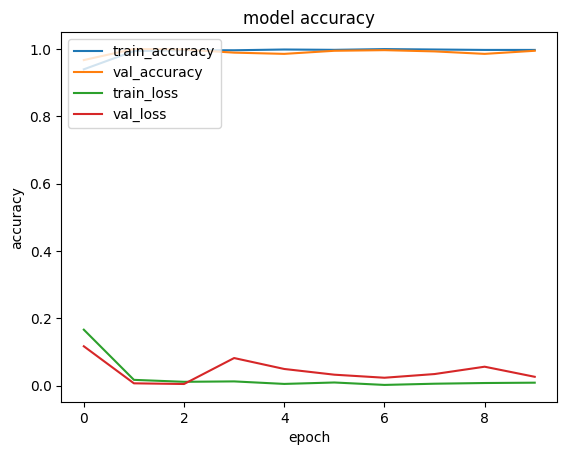

K-Fold Results:
Acuracy: 0.9350831747055054 	 +/- 0.03820575130704595
Precision: 0.8754331111907959 	 +/- 0.10389465710496788
Recall: 0.890670907497406 	 +/- 0.07199548227601898
AUC: 0.9639856820200743 	 +/- 0.019333938102348826
F1: 0.8764770545900978 	 +/- 0.05500351996835992


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9562571048736572, Test Precision: 0.9669421315193176, Test Recall: 0.8602941036224365, Test AUC: 0.9794401855149447, Test F1 Score: 0.9105058210775308


In [17]:
# ptbxl smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="supervised_ptbxl_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9395833611488342, Val Precision: 0.8940397500991821, Val Recall: 0.912162184715271, Val AUC: 0.9766769781830023, Val F1 Score: 0.9030100521473976
Test Accuracy: 0.9514390826225281, Test Precision: 0.9063266515731812, Test Recall: 0.9058823585510254, Test AUC: 0.9820207782103776,Test F1 Score: 0.9061044505992106

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9647495150566101, Val Precision: 0.9770992398262024, Val Recall: 0.8888888955116272, Val AUC: 0.9940400843881856, Val F1 Score: 0.9309090959864215
Test Accuracy: 0.9514390826225281, Test Precision: 0.9199188947677612, Test Recall: 0.8897058963775635, Test AUC: 0.9830692461694784,Test F1 Score: 0.9045601816120136

Training on fold 3
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9963235259056091, Val Precision: 1.0, Val Recall: 0.9729729890823364, Val AUC: 0.9996549741230591, V

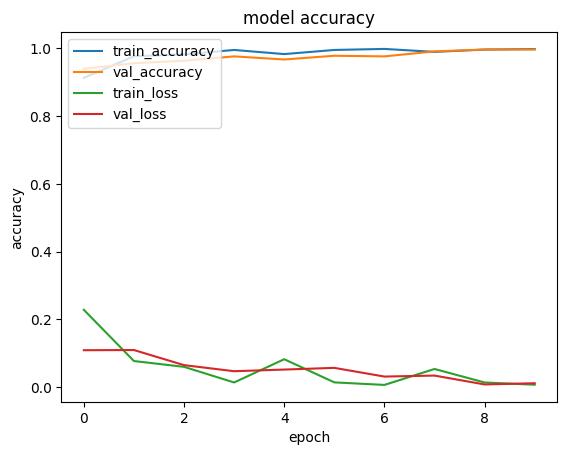

K-Fold Results:
Acuracy: 0.9420440912246704 	 +/- 0.03577138144376426
Precision: 0.8807840466499328 	 +/- 0.10131408618685926
Recall: 0.8760169267654419 	 +/- 0.06835684782791349
AUC: 0.9760012384438845 	 +/- 0.02015522912771654
F1: 0.8777568399803071 	 +/- 0.08291001838896848


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9114999175071716, Test Precision: 0.8576759099960327, Test Recall: 0.7887254953384399, Test AUC: 0.9527146064514398, Test F1 Score: 0.8217568993316554


In [18]:
# norm+rbbb no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="supervised_zhongshang_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9312499761581421, Val Precision: 0.8285714387893677, Val Recall: 0.9797297120094299, Val AUC: 0.9915947574080105, Val F1 Score: 0.8978328158954639
Test Accuracy: 0.9156840443611145, Test Precision: 0.7856252789497375, Test Recall: 0.9269607663154602, Test AUC: 0.9690285281206718,Test F1 Score: 0.8504609886614786

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9573283791542053, Val Precision: 1.0, Val Recall: 0.8402777910232544, Val AUC: 0.9964135021097047, Val F1 Score: 0.9132075549920456
Test Accuracy: 0.9449727535247803, Test Precision: 0.9402412176132202, Test Recall: 0.8406862616539001, Test AUC: 0.9781211749279837,Test F1 Score: 0.8876811475933327

Training on fold 3
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9963235259056091, Val Precision: 1.0, Val Recall: 0.9729729890823364, Val AUC: 0.9999712478435884, Val F1 Score: 0

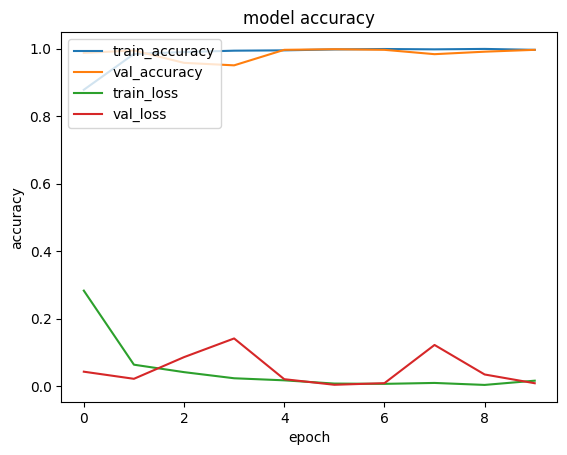

K-Fold Results:
Acuracy: 0.9494855999946594 	 +/- 0.029475813885583194
Precision: 0.9042391419410706 	 +/- 0.08198409319701397
Recall: 0.893596088886261 	 +/- 0.07831804636286807
AUC: 0.9808018234196817 	 +/- 0.02713277920738951
F1: 0.8961446003820782 	 +/- 0.06227847780595964


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9575250148773193, Test Precision: 0.896696150302887, Test Recall: 0.9446078538894653, Test AUC: 0.9856266578805286, Test F1 Score: 0.9200286581683561


In [19]:
# norm+rbbb smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="supervised_zhongshang_smote.h5")

# SimCLR Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9375, Val Precision: 1.0, Val Recall: 0.7972972989082336, Val AUC: 0.996336698143927, Val F1 Score: 0.8872180461101801
Test Accuracy: 0.9509319067001343, Test Precision: 0.9479674696922302, Test Recall: 0.8573529124259949, Test AUC: 0.9700271967860172,Test F1 Score: 0.9003860800287696

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9870129823684692, Val Precision: 0.9597315192222595, Val Recall: 0.9930555820465088, Val AUC: 0.9983473980309423, Val F1 Score: 0.9761092151934154
Test Accuracy: 0.9245594143867493, Test Precision: 0.8585608005523682, Test Recall: 0.8480392098426819, Test AUC: 0.9576096506671763,Test F1 Score: 0.8532675711560426

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9963235259056091, Val Precision: 1.0, Val Recall: 0.9729729890823364, Val AUC: 0.9986774008050604, Val F1 Score: 0.986301378139

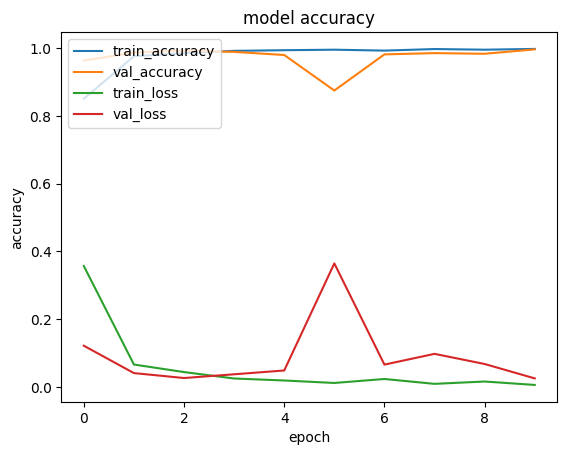

K-Fold Results:
Acuracy: 0.9415517807006836 	 +/- 0.0447742963345834
Precision: 0.9073696136474609 	 +/- 0.11997545215870423
Recall: 0.846150028705597 	 +/- 0.12385505464658805
AUC: 0.9719904213552033 	 +/- 0.03334403111702197
F1: 0.8695666477831974 	 +/- 0.10443587167747281


247/247 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9410422444343567, Test Precision: 0.9120879173278809, Test Recall: 0.854411780834198, Test AUC: 0.9543955841272715, Test F1 Score: 0.8823082874367609


In [20]:
# ptbxl no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.001, num_classes=1, name="simclr_ptbxl_no_smote.h5")


Training on fold 1
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9416666626930237, Val Precision: 0.8409090638160706, Val Recall: 1.0, Val AUC: 0.9954005210029306, Val F1 Score: 0.9135802309245273
Test Accuracy: 0.944212019443512, Test Precision: 0.8499562740325928, Test Recall: 0.9524509906768799, Test AUC: 0.9855159927832943,Test F1 Score: 0.8982894277946237

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9888682961463928, Val Precision: 0.9599999785423279, Val Recall: 1.0, Val AUC: 0.9997011251758088, Val F1 Score: 0.9795918255634776
Test Accuracy: 0.9405350685119629, Test Precision: 0.8826107978820801, Test Recall: 0.8882352709770203, Test AUC: 0.9720860706177459,Test F1 Score: 0.8854141023438789

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.998161792755127, Val Precision: 1.0, Val Recall: 0.9864864945411682, Val AUC: 0.9998562392179414, Val F1 Score: 0.9931972829938855

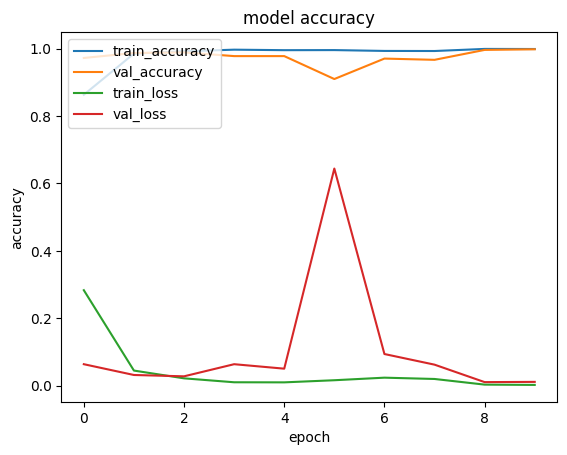

K-Fold Results:
Acuracy: 0.9450099229812622 	 +/- 0.043395009288965156
Precision: 0.882364284992218 	 +/- 0.10864516999848618
Recall: 0.8926003336906433 	 +/- 0.13586987784413726
AUC: 0.9797185106643228 	 +/- 0.024596806184095505
F1: 0.8806719330709096 	 +/- 0.1034685625617549


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.9562571048736572, Test Precision: 0.9568732976913452, Test Recall: 0.8700980544090271, Test AUC: 0.9787855846973645, Test F1 Score: 0.9114249040413507


In [21]:
# ptbxl smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.001, num_classes=1, name="simclr_ptbxl_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.8958333134651184, Val Precision: 1.0, Val Recall: 0.662162184715271, Val AUC: 0.9628785411917943, Val F1 Score: 0.7967479838060443
Test Accuracy: 0.9041460752487183, Test Precision: 0.8958076238632202, Test Recall: 0.7122548818588257, Test AUC: 0.9093627702491976,Test F1 Score: 0.7935554134650277

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8775510191917419, Val Precision: 1.0, Val Recall: 0.5416666865348816, Val AUC: 0.9859528832630098, Val F1 Score: 0.7027027194216094
Test Accuracy: 0.8937492370605469, Test Precision: 0.9539275169372559, Test Recall: 0.6191176176071167, Test AUC: 0.9118477885424735,Test F1 Score: 0.7508917814073145

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9503676295280457, Val Precision: 0.7326732873916626, Val Recall: 1.0, Val AUC: 0.9994537090281771, Val F1 Score: 0.845714299081296

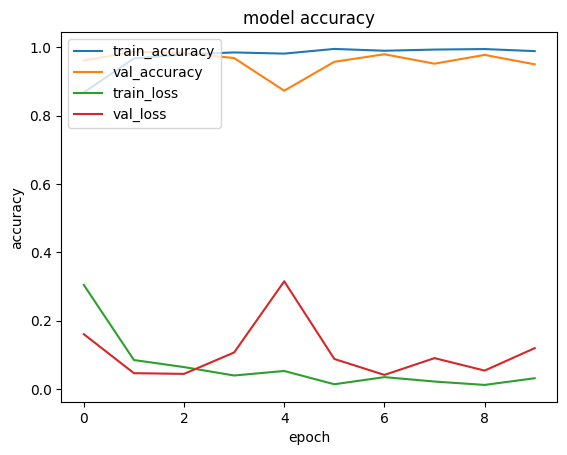

K-Fold Results:
Acuracy: 0.8991273522377015 	 +/- 0.02645881374694739
Precision: 0.8664121150970459 	 +/- 0.11274648392307182
Recall: 0.692432451248169 	 +/- 0.15996931172733755
AUC: 0.9590740662091302 	 +/- 0.034816613330188255
F1: 0.7507139211938645 	 +/- 0.06207133589915675


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.8943831324577332, Test Precision: 0.7474374771118164, Test Recall: 0.8936274647712708, Test AUC: 0.9425920616236917, Test F1 Score: 0.8140209941722732


In [22]:
# BARD no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/simclr-bard_epoch_3.h5', learning_rate=0.001, num_classes=1, name="simclr_bard_no_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9208333492279053, Val Precision: 1.0, Val Recall: 0.7432432174682617, Val AUC: 0.965076522305438, Val F1 Score: 0.8527131613311939
Test Accuracy: 0.8995816111564636, Test Precision: 0.945078432559967, Test Recall: 0.6495097875595093, Test AUC: 0.9003169465152232,Test F1 Score: 0.7699011998384206

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8831169009208679, Val Precision: 0.7612903118133545, Val Recall: 0.8194444179534912, Val AUC: 0.9458333333333334, Val F1 Score: 0.7892976407870032
Test Accuracy: 0.8998351693153381, Test Precision: 0.8045808672904968, Test Recall: 0.8093137145042419, Test AUC: 0.9348792912068197,Test F1 Score: 0.8069403512115307

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9522058963775635, Val Precision: 0.7790697813034058, Val Recall: 0.9054054021835327, Val AUC: 0.9830937320299022, Va

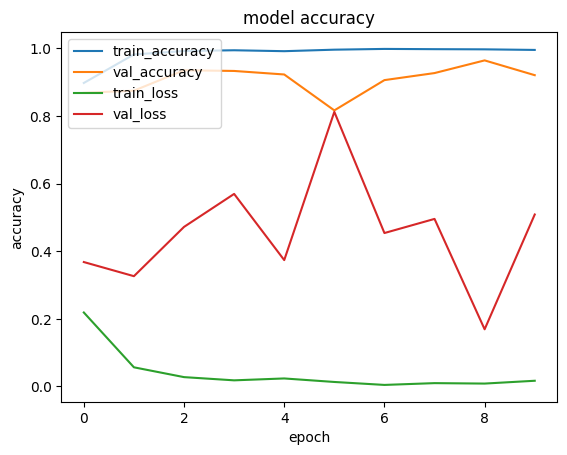

K-Fold Results:
Acuracy: 0.921448826789856 	 +/- 0.022137411960945198
Precision: 0.8729536890983581 	 +/- 0.0903992502933803
Recall: 0.7840731620788575 	 +/- 0.06979347419490269
AUC: 0.9650534884245132 	 +/- 0.012862420829316103
F1: 0.8193230125420913 	 +/- 0.022890741202067088


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.8995816111564636, Test Precision: 0.945078432559967, Test Recall: 0.6495097875595093, Test AUC: 0.9003169465152232, Test F1 Score: 0.7699011998384206


In [23]:
# BARD smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/simclr-bard_epoch_3.h5', learning_rate=0.001, num_classes=1, name="simclr_bard_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9104166626930237, Val Precision: 0.8301886916160583, Val Recall: 0.8918918967247009, Val AUC: 0.9837390100944318, Val F1 Score: 0.8599348623031209
Test Accuracy: 0.9127678275108337, Test Precision: 0.842799186706543, Test Recall: 0.8147059082984924, Test AUC: 0.9416132623735316,Test F1 Score: 0.8285144691116607

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.948051929473877, Val Precision: 0.8766233921051025, Val Recall: 0.9375, Val AUC: 0.9929852320675105, Val F1 Score: 0.9060402767254765
Test Accuracy: 0.9198681116104126, Test Precision: 0.8809523582458496, Test Recall: 0.7980391979217529, Test AUC: 0.9332436275348175,Test F1 Score: 0.8374485396299579

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9779411554336548, Val Precision: 0.8604651093482971, Val Recall: 1.0, Val AUC: 0.9997124784358826, Val F1 Score: 

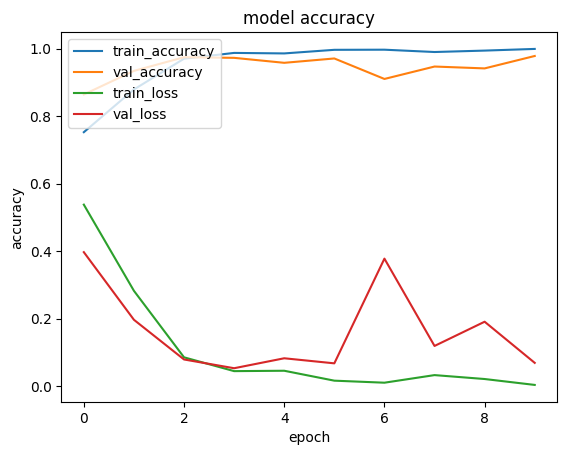

K-Fold Results:
Acuracy: 0.9375038146972656 	 +/- 0.023690740919107764
Precision: 0.9020918011665344 	 +/- 0.06136103478056314
Recall: 0.836938989162445 	 +/- 0.13480287324056853
AUC: 0.9814020066870336 	 +/- 0.017719868498565442
F1: 0.8573732555223479 	 +/- 0.05293722814572816


247/247 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9197413325309753, Test Precision: 0.876807689666748, Test Recall: 0.802450954914093, Test AUC: 0.9282349420014285, Test F1 Score: 0.8379830827367583


In [24]:
# norm+rbbb no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="simclr_zhongshang_no_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9145833253860474, Val Precision: 0.8022598624229431, Val Recall: 0.9594594836235046, Val AUC: 0.9840646369260827, Val F1 Score: 0.8738461492854456
Test Accuracy: 0.9101052284240723, Test Precision: 0.8031890392303467, Test Recall: 0.8642156720161438, Test AUC: 0.9449757626669617,Test F1 Score: 0.8325855751907405

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9424861073493958, Val Precision: 0.8896551728248596, Val Recall: 0.8958333134651184, Val AUC: 0.9892756680731365, Val F1 Score: 0.8927335543553205
Test Accuracy: 0.9330543875694275, Test Precision: 0.9140197038650513, Test Recall: 0.8181372284889221, Test AUC: 0.9443862195126042,Test F1 Score: 0.8634247086240379

Training on fold 3
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9779411554336548, Val Precision: 0.8604651093482971, Val Recall: 1.0, Val AUC: 0.9993387004025303, 

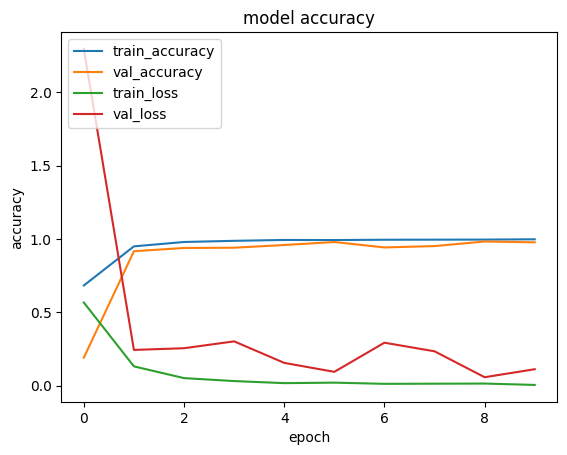

K-Fold Results:
Acuracy: 0.9293100714683533 	 +/- 0.028176440617308576
Precision: 0.8886291742324829 	 +/- 0.054829400886600786
Recall: 0.8115131020545959 	 +/- 0.1757317900378603
AUC: 0.9792474362236359 	 +/- 0.015792012232538812
F1: 0.832065935386446 	 +/- 0.08202220370991845


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.9283631443977356, Test Precision: 0.8627643585205078, Test Recall: 0.8598039150238037, Test AUC: 0.9524213020251713, Test F1 Score: 0.8612815928306958


In [25]:
# norm+rbbb smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="simclr_zhongshang_smote.h5")

# MoCo v2 Pretraining


Training on fold 1
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.8979166746139526, Val Precision: 0.9900990128517151, Val Recall: 0.6756756901741028, Val AUC: 0.9607009117551286, Val F1 Score: 0.8032128626207284
Test Accuracy: 0.9215164184570312, Test Precision: 0.9191740155220032, Test Recall: 0.7637255191802979, Test AUC: 0.9180306978272754,Test F1 Score: 0.8342704216693028

Training on fold 2
247/247 [==============================] - 1s 4ms/step
Val Accuracy: 0.9461966753005981, Val Precision: 0.8616352081298828, Val Recall: 0.9513888955116272, Val AUC: 0.9716947960618847, Val F1 Score: 0.9042904254280226
Test Accuracy: 0.9347026944160461, Test Precision: 0.8888322114944458, Test Recall: 0.854411780834198, Test AUC: 0.9506893094162584,Test F1 Score: 0.8712821796922587

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9577205777168274, Val Precision: 0.8399999737739563, Val Recall: 0.8513513803482056, Val AUC: 0.9797

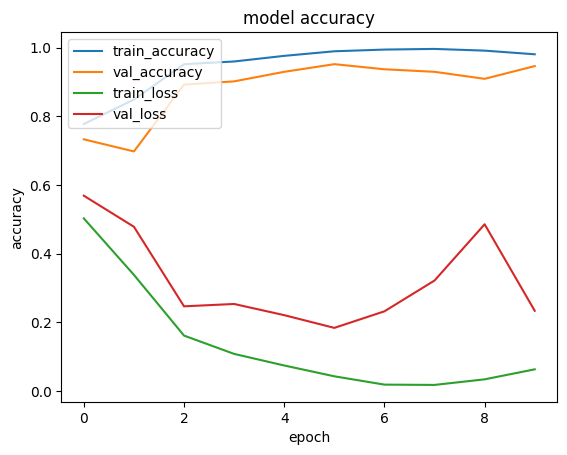

K-Fold Results:
Acuracy: 0.9151175498962403 	 +/- 0.03096909442670461
Precision: 0.8802845001220703 	 +/- 0.059716951302235324
Recall: 0.7246225953102112 	 +/- 0.1541710442202173
AUC: 0.9448636822841883 	 +/- 0.032731223623376396
F1: 0.7848529629762832 	 +/- 0.09031476130361132


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.9347026944160461, Test Precision: 0.8888322114944458, Test Recall: 0.854411780834198, Test AUC: 0.9506893094162584, Test F1 Score: 0.8712821796922587


In [26]:
# ptbxl no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.001, num_classes=1, name="moco_ptbxl_no_smote.h5")


Training on fold 1
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.8604166507720947, Val Precision: 0.7755101919174194, Val Recall: 0.7702702879905701, Val AUC: 0.9367062845978509, Val F1 Score: 0.7728813588115817
Test Accuracy: 0.9225307703018188, Test Precision: 0.8782424330711365, Test Recall: 0.8132352828979492, Test AUC: 0.9508791168254545,Test F1 Score: 0.8444896752333476

Training on fold 2
247/247 [==============================] - 1s 5ms/step
Val Accuracy: 0.9610389471054077, Val Precision: 0.8819875717163086, Val Recall: 0.9861111044883728, Val AUC: 0.9933192686357244, Val F1 Score: 0.9311475347300044
Test Accuracy: 0.941169023513794, Test Precision: 0.8975781798362732, Test Recall: 0.8720588088035583, Test AUC: 0.9596752314744952,Test F1 Score: 0.8846344909615756

Training on fold 3
247/247 [==============================] - 2s 5ms/step
Val Accuracy: 0.9319853186607361, Val Precision: 0.7078651785850525, Val Recall: 0.8513513803482056, Val AUC: 0.9605

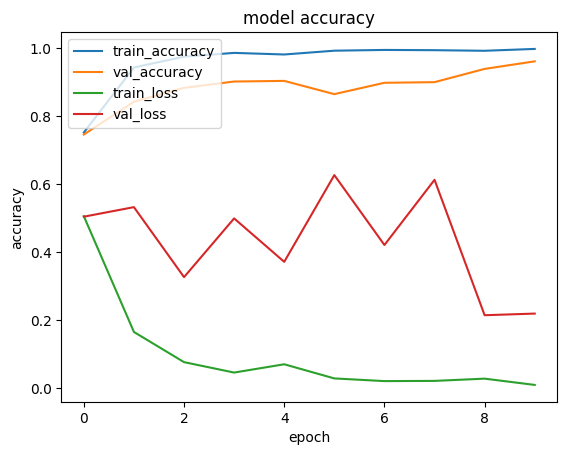

K-Fold Results:
Acuracy: 0.9156511545181274 	 +/- 0.035545011297934415
Precision: 0.8244239330291748 	 +/- 0.07536750263917355
Recall: 0.8039708018302918 	 +/- 0.13754264173749733
AUC: 0.9540183454676242 	 +/- 0.023055242313961034
F1: 0.8039389859649522 	 +/- 0.07760674617082149


247/247 [==============================] - 2s 5ms/step

Test Performance:
Test Accuracy: 0.941169023513794, Test Precision: 0.8975781798362732, Test Recall: 0.8720588088035583, Test AUC: 0.9596752314744952, Test F1 Score: 0.8846344909615756


In [27]:
# ptbxl smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.001, num_classes=1, name="moco_ptbxl_smote.h5")

In [28]:
# BARD no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_5.h5', learning_rate=0.001, num_classes=1, name="moco_bard_no_smote.h5")


Training on fold 1
15/15 [==============================] - 0s 4ms/step


ZeroDivisionError: float division by zero

In [ ]:
# BARD smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_5.h5', learning_rate=0.001, num_classes=1, name="moco_bard_smote.h5")

In [ ]:
# norm+rbbb no smote
k_fold_finetune_resnet(5, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="moco_zhongshang_no_smote.h5")

In [ ]:
# norm+rbbb smote
k_fold_finetune_resnet(5, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="moco_zhongshang_smote.h5")